# Project Kilonova Afterglow

# Goal

Consider ejecta properties from a set of high-resolution neutrino-radiation GRHD simulations. 
- Looking at mass flux as a function of extraction time, asses ejecta mechanism 
- 

[NOTEBOOK TOOLS](https://www.jetbrains.com/help/dataspell/code-folding-commands.html)

# Section 1 Simulation Data
--- 

In [1]:
import numpy as np
import h5py
import pandas as pd
from glob import glob
import os
import re
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm, Normalize
# settings
plt.style.use("fivethirtyeight")

# Supress runtime warning
import warnings
warnings.filterwarnings("ignore")

import PyBlastAfterglowMag as PBA
from ejecta import ProcessRaw
from settings import *

df = SIMS[SIMS["given_time"] == "new"]


# color_pal = sns.color_palette(n_colors=len(df))

np.set_printoptions(precision=2)

figs = os.getcwd()+"/figs/"
out = os.getcwd()+"/out/"
pdfs = "/home/vsevolod/Work/GIT/overleaf/knafg_kenta_paper/figs/"
print("AVAILABLE SIMULATION DATA")
df.head()
df.to_csv(out+"sim_meta.csv",index=False)

AVAILABLE SIMULATION DATA


In [2]:
#pr = ProcessRaw(simumlation=SIMS.T["DD2_135_135_res150"])
#pr.process_raw_ejecta_files(infiles= "ejecta_*.h5", fname_output= "ej_collated.h5", mode="mass",overwrite=False)
#pr.process_raw_ejecta_files(infiles="Mdot_ejecta_*.h5", fname_output="mdot_ej_collated.h5", mode="mdot",overwrite=False)
# Collate data for simulations (USE ONLY ONCE)\
for sim_key, sim_dic in SIMS.items():
    pr = ProcessRaw(simumlation=sim_dic)
    #pr.process_raw_ejecta_files(infiles= "ejecta_*.h5", fname_output= "ej_collated.h5", mode="mass",overwrite=False)
    #pr.process_raw_ejecta_files(infiles="Mdot_ejecta_*.h5", fname_output="mdot_ej_collated.h5", mode="mdot",overwrite=False)

In [3]:
# collect tmin tmax for all simulations
df["tmin"],df["tmax"] = pd.Series(dtype = 'object'), pd.Series(dtype = 'object')
data = None
for sim, sim_dic in df.iterrows():
    print(f"processing {sim} {sim_dic['name']}")
    data = PBA.id_kenta.EjectaData(sim_dic["datadir"]+"ej_collated.h5",verbose=True)
    df["tmin"][sim] = np.array(data.getText().min())
    df["tmax"][sim] = np.array(data.getText().max())
print(df[["name","tmin","tmax"]])

processing SFHo_135_135_res150_new SFHoTim276_135_135_45km_150mstg_B0_FUKA
processing SFHo_13_14_res150 SFHoTim276_13_14_0025_150mstg_B0_HLLC
processing SFHo_12_15_res150_B15_HLLD SFHoTim276_12_15_0025_150mstg_B15_HLLD_CT_GS_onFugaku
processing BHBLp_135_135_res150 BHBLpTim326_135_135_45km_150mstg_B0_HLLC
processing DD2_135_135_res150 DD2Tim326_135_135_0028_12.5mstg_B15.5_HLLD_CT_GS
                                                                         name  \
SFHo_135_135_res150_new               SFHoTim276_135_135_45km_150mstg_B0_FUKA   
SFHo_13_14_res150                       SFHoTim276_13_14_0025_150mstg_B0_HLLC   
SFHo_12_15_res150_B15_HLLD  SFHoTim276_12_15_0025_150mstg_B15_HLLD_CT_GS_o...   
BHBLp_135_135_res150                 BHBLpTim326_135_135_45km_150mstg_B0_HLLC   
DD2_135_135_res150           DD2Tim326_135_135_0028_12.5mstg_B15.5_HLLD_CT_GS   

                                            tmin                tmax  
SFHo_135_135_res150_new     0.057651109993457794    47.9

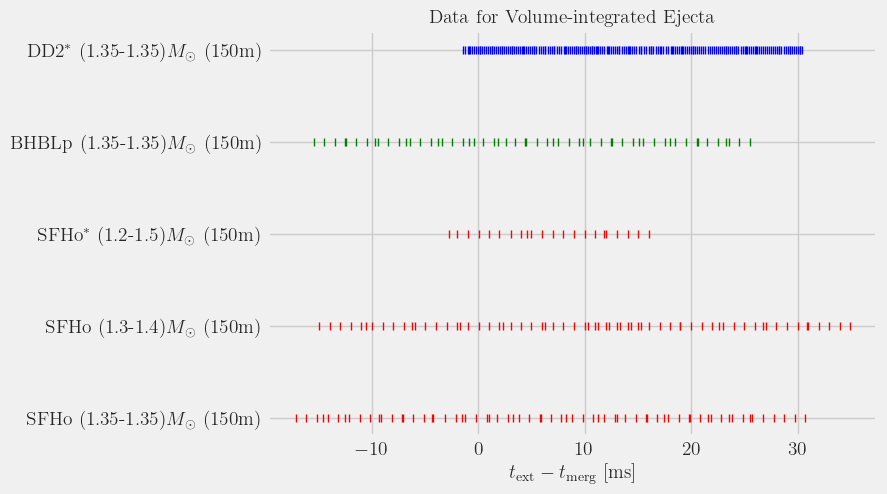

In [4]:
def plot_simulation_available_time():
    # Plot extraction time for all simulations
    fig, ax = plt.subplots(figsize=(7,5))
    for idx, sim_dic in enumerate(df.iterrows()):
        sim_dic = sim_dic[1]
        data = PBA.id_kenta.EjectaData(sim_dic["datadir"]+"ej_collated.h5",verbose=True)
        tmerg = sim_dic["tmerg"]
        ax.plot(data.getText()-tmerg, np.full_like(data.getText(), int(idx)),  marker="|", color=sim_dic["color"], linestyle="None")
    ax.set_yticks(np.arange(len(df)))
    ticks_loc = ax.get_yticks().tolist()
    ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    ax.set_yticklabels(df["label"].to_list(),fontsize=14)
    ax.set_xlabel(r"$t_{\rm ext} - t_{\rm merg}$ [ms]", fontsize=14)
    ax.tick_params(labelsize=14)
    ax.minorticks_on()
    ax.set_title("Data for Volume-integrated Ejecta",fontsize=14)
    plt.savefig(figs+"ejecta.png", dpi=256)
    plt.show()
plot_simulation_available_time()

In [5]:
def get_vave_theta_rms(sim_dic:dict, crit:str) -> pd.DataFrame:
    vals = {"vave":[], "ye_ave":[], "theta_rms":[], 
            "entr_ave":[],"eps_ave":[],"temp_ave":[], 
            "time":[], "mass":[], "ek":[]}
    
    ej = PBA.id_kenta.EjectaData(sim_dic["datadir"]+"ej_collated.h5",verbose=True)
    
    for it, text in enumerate(ej.getText()):
        
        ej_mass = ej.get(v_n="mass",text=text)       
        
        mask = ej.get_vinf_mask(crit=crit)
        
        vals["mass"].append( np.sum(ej_mass[:,mask]) )
                
        ej_vinf = ej.get_vinf()
        vals["vave"].append( np.sum(ej_mass[:,mask]*ej_vinf[mask])/np.sum(ej_mass[:,mask]) )

        solar_m = 1.989e+33
        c = 2.9979e10
        vals["ek"].append(np.sum( ej_mass[:,mask] * solar_m * (ej_vinf[np.newaxis, mask] * c) ** 2 ))


        for v_n in ["ye","entr","eps","temp"]:
            ave = ej.get(v_n=v_n,text=text)
            vals[f"{v_n}_ave"].append( np.sum(ej_mass[:,mask]*ave[:,mask])/np.sum(ej_mass[:,mask]) )
    
        thetas = ej.get_theta()
        vals["theta_rms"].append( (180. / np.pi) * np.sqrt(np.sum(np.sum(ej_mass[:,mask], axis=1) * thetas ** 2) / np.sum(ej_mass[:,mask])) )
    # vals = {key:np.array(vals) for (key,val) in vals.items()}


    tmerg = sim_dic["tmerg"]
    times = ej.getText()
    vals["time"] = times #- tmerg
    
    return pd.DataFrame.from_dict(vals)

In [6]:
def print_table(crit:str="fast") -> pd.DataFrame:
    df_res = { sim_dic["name"] : {} for _, sim_dic in df.iterrows()}
    for idx, sim_dic in enumerate(df.iterrows()):
        
        sim_dic = sim_dic[1]

        df_res[sim_dic["name"]]["name"] = sim_dic["name"]
        df_res[sim_dic["name"]]["label"] = sim_dic["label"]
        
        df_ave = get_vave_theta_rms(sim_dic=sim_dic, crit=crit)
        idx = df_ave["mass"].argmax()
        
        df_res[sim_dic["name"]]["text"] = df_ave["time"][idx] - sim_dic["tmerg"]
        df_res[sim_dic["name"]]["mass"] = df_ave["mass"][idx]
        df_res[sim_dic["name"]]["vave"] = df_ave["vave"][idx]
        df_res[sim_dic["name"]]["ye_ave"] = df_ave["ye_ave"][idx]
        df_res[sim_dic["name"]]["eps_ave"] = df_ave["eps_ave"][idx]
        df_res[sim_dic["name"]]["temp_ave"] = df_ave["temp_ave"][idx]
        df_res[sim_dic["name"]]["theta_rms"] = df_ave["theta_rms"][idx]
        df_res[sim_dic["name"]]["ek"] = df_ave["ek"][idx]
    df_res = pd.DataFrame.from_dict(df_res).T
    return df_res
print("EJECTA PROPERTIES AT EXTRACTION TIME WHEN MASS IS MAX ")
df_res = print_table(crit=None)
df_res.to_csv(out+"ejecta_vals_at_massmax.csv",index=False)

EJECTA PROPERTIES AT EXTRACTION TIME WHEN MASS IS MAX 


In [7]:
print("FAST TAIL PROPERTIES AT EXTRACTION TIME WHEN MASS IS MAX ")
df_res = print_table(crit="fast")
df_res.to_csv(out+"ejecta_fasttail_vals_at_massmax.csv",index=False)

FAST TAIL PROPERTIES AT EXTRACTION TIME WHEN MASS IS MAX 


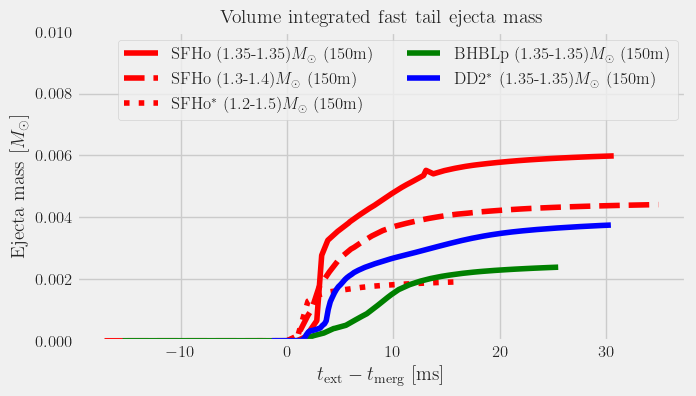

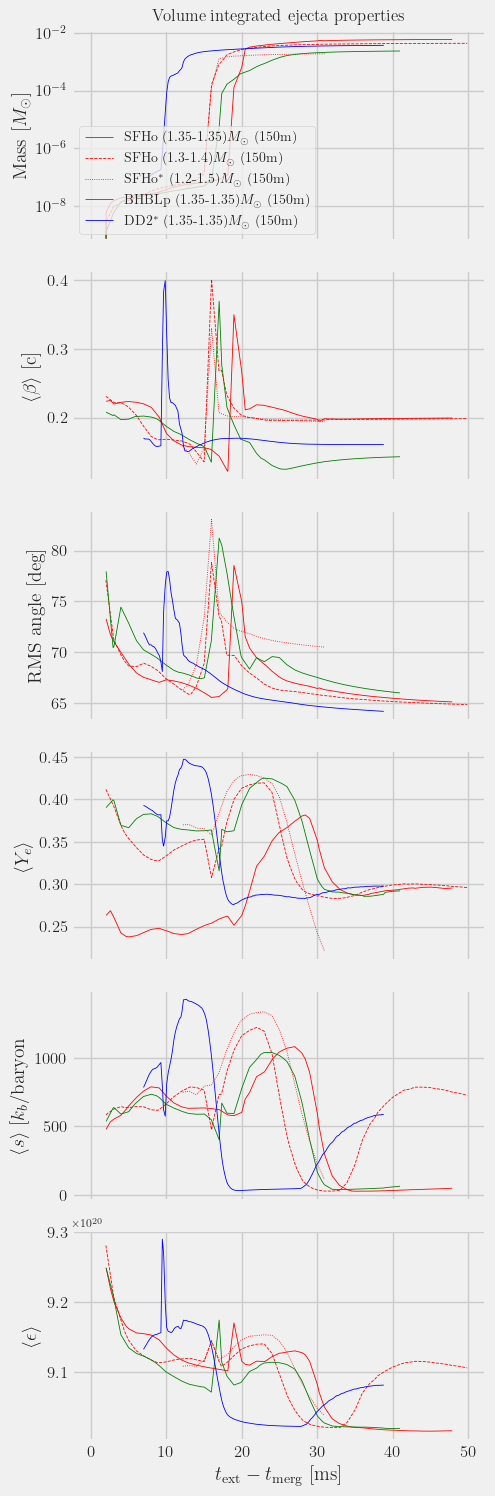

In [8]:
# Ejecta mass evolution of all simulation
def plot_all_sim_ejecta_mass(crit=None,yscale="linear",ylim=(0,0.04),title="Volume integrated ejecta mass",
                             figname="figname"):
    fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(7,4))
    #ax2 = ax.twinx()
    for idx, sim_dic in enumerate(df.iterrows()):
        sim_dic = sim_dic[1]
        ej = PBA.id_kenta.EjectaData(sim_dic["datadir"]+"ej_collated.h5",verbose=True)
        if (crit is None):
            mass = ej.total_mass()
        else:
            mass = ej.total_mass_vs_text(crit=crit)
        tmerg = sim_dic["tmerg"]
        if sim_dic["given_time"] == "new":
            ax.plot(ej.getText()-tmerg, mass, 
                    color=sim_dic["color"], ls=sim_dic["ls"], label=sim_dic["label"])
        else:
            ax.plot(ej.getText()-tmerg, mass, color=sim_dic["color"], ls=sim_dic["ls"],
                label=sim_dic["label"])
        # data = PBA.id_kenta.Data(fpath_rhomax=sim_dic["datadir"]+sim_dic["rhomax"],
        #                          fpath_mdot=sim_dic["datadir"]+sim_dic["mdot_extract"])
        # ax.plot(ej.getText(), ej.total_mass_fasttail(),color=color_pal[sim_dic["idx"]],
        #         label=r"$\Gamma\beta>1$",ls="--")
        # ax2.plot(*data.get_rhomax(),color=color_pal[sim_dic["idx"]],label=r"$\rho_{\rm max}$",ls=":")
        # ax2.plot(*data.get_mdot(),color=color_pal[sim_dic["idx"]],label=r"$\dot{M}$",ls="-.")
    ax.tick_params(labelsize=12)
    ax.set_ylim(*ylim)
    ax.set_yscale(yscale)
    ax.legend(fontsize=12,ncol=2)
    # ax.set_yscale("log")
    ax.set_xlabel(r"$t_{\rm ext} - t_{\rm merg}$ [ms]",fontsize=14)
    ax.set_ylabel(r"Ejecta mass $[M_{\odot}]$",fontsize=14)
    ax.set_title(title,fontsize=14)
    # ax.grid(which="both",axis="both")
    plt.tight_layout()
    plt.savefig(figs+figname,dpi=256)
    plt.show()
def plot_all_sim_ejecta_massave_vel(crit=None,yscale="linear",ylim=(0,0.04),title="Volume integrated ejecta mass", figfpath:str="mej_vej_theta.png"):
    fig, ax = plt.subplots(ncols=1,nrows=6,sharex="all",figsize=(5,15))
    #ax2 = ax.twinx()
    for idx, sim_dic in enumerate(df.iterrows()):
        sim_dic = sim_dic[1]

        df_ave = get_vave_theta_rms(sim_dic=sim_dic, crit=crit)

        ax[0].plot(df_ave["time"], df_ave["mass"], color=sim_dic["color"], label=sim_dic["label"], ls=sim_dic["ls"], lw=.6)

        # ---

        ax[1].plot(df_ave["time"], df_ave["vave"], color=sim_dic["color"], ls=sim_dic["ls"], lw=.6)
        ax[2].plot(df_ave["time"], df_ave["theta_rms"], color=sim_dic["color"], ls=sim_dic["ls"],lw=.6)
        ax[3].plot(df_ave["time"], df_ave["ye_ave"], color=sim_dic["color"], ls=sim_dic["ls"], lw=.6)
        ax[4].plot(df_ave["time"], df_ave["entr_ave"], color=sim_dic["color"], ls=sim_dic["ls"],lw=.6)
        ax[5].plot(df_ave["time"], df_ave["eps_ave"], color=sim_dic["color"], ls=sim_dic["ls"], lw=.6)
      
        

    for _ax in ax:
        _ax.tick_params(labelsize=12)
        _ax.minorticks_on()
    # ax[0].set_ylim(*ylim)
    ax[0].set_yscale(yscale)
    ax[0].legend(fontsize=10,ncol=1,loc="lower left")
    ax[0].set_yscale("log")
    #ax[5].set_yscale("log")
    # ax[-1].set_xlabel("Extraction time [ms]",fontsize=14)
    ax[-1].set_xlabel(r"$t_{\rm ext} - t_{\rm merg}$ [ms]", fontsize=14)
    ax[0].set_ylabel(r"Mass [$M_{\odot}$]",fontsize=14)
    ax[1].set_ylabel(r"$\langle\beta\rangle$ [c]",fontsize=14)
    ax[2].set_ylabel(r"RMS angle [deg]",fontsize=14)
    ax[3].set_ylabel(r"$\langle Y_e \rangle$",fontsize=14)
    ax[4].set_ylabel(r"$\langle s \rangle$ [$k_b/$baryon",fontsize=14)
    ax[5].set_ylabel(r"$\langle \epsilon \rangle$",fontsize=14)
    ax[0].set_title(title,fontsize=12)
    # ax.grid(which="both",axis="both")
    plt.tight_layout()
    plt.savefig(figs+figfpath,dpi=512)
    plt.savefig(pdfs+figfpath.replace(".png",".pdf"))
    plt.show()
plot_all_sim_ejecta_mass(crit=None,yscale="linear",ylim=(0., 0.01),figname="ejecta_mass_evol.png",
                         title="Volume integrated fast tail ejecta mass")
plot_all_sim_ejecta_massave_vel(ylim=(0., 0.01),
                                title="Volume integrated ejecta properties",
                                figfpath="mej_vej_theta.png")

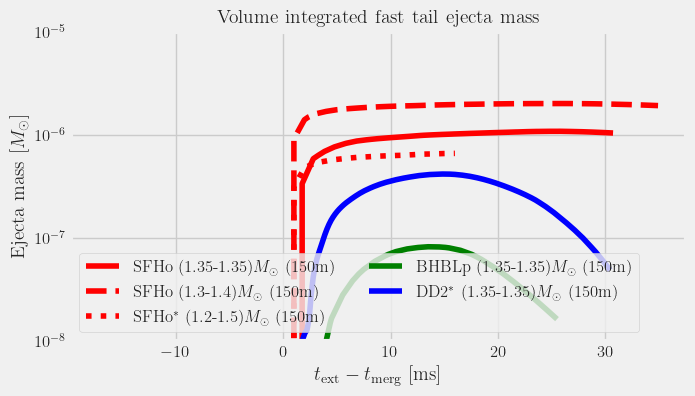

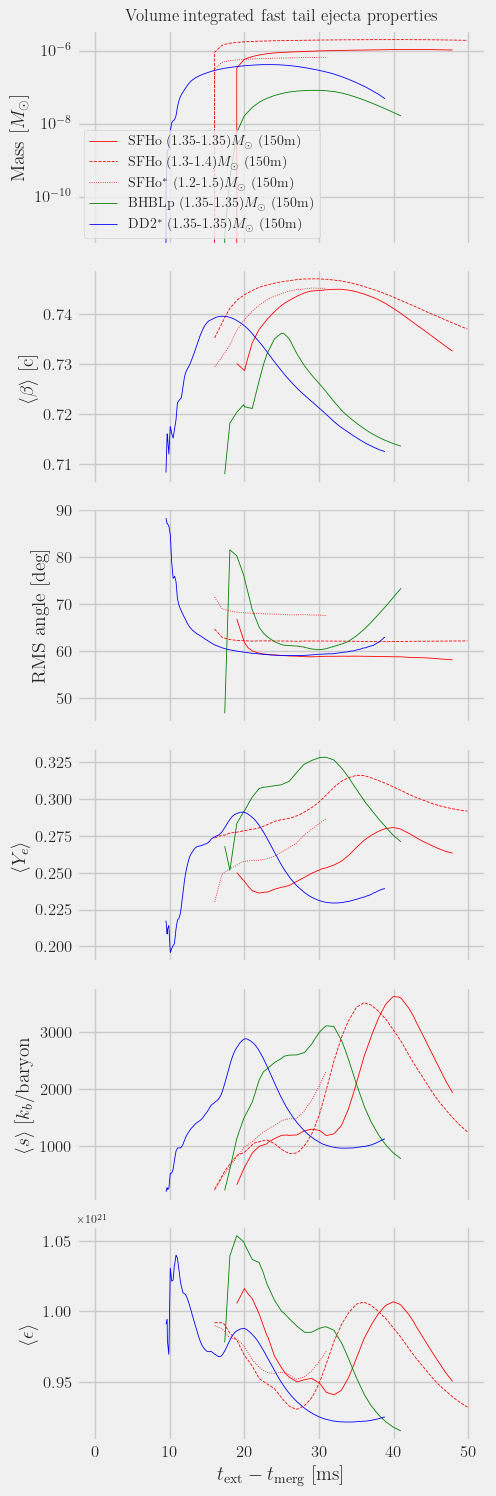

In [9]:
# Ejecta mass fast tail evolution of all simulations
plot_all_sim_ejecta_mass(crit="fast",yscale="log",ylim=(1e-8,1e-5),figname="ejecta_fasttail_mass_evol.png",
                         title="Volume integrated fast tail ejecta mass")
plot_all_sim_ejecta_massave_vel(
    crit="fast",yscale="log",ylim=(1e-7,1e-5),
    title="Volume integrated fast tail ejecta properties",
    figfpath="mej_vej_theta_fasttail.png"
)

# Separate Analysis Of Each Simulation

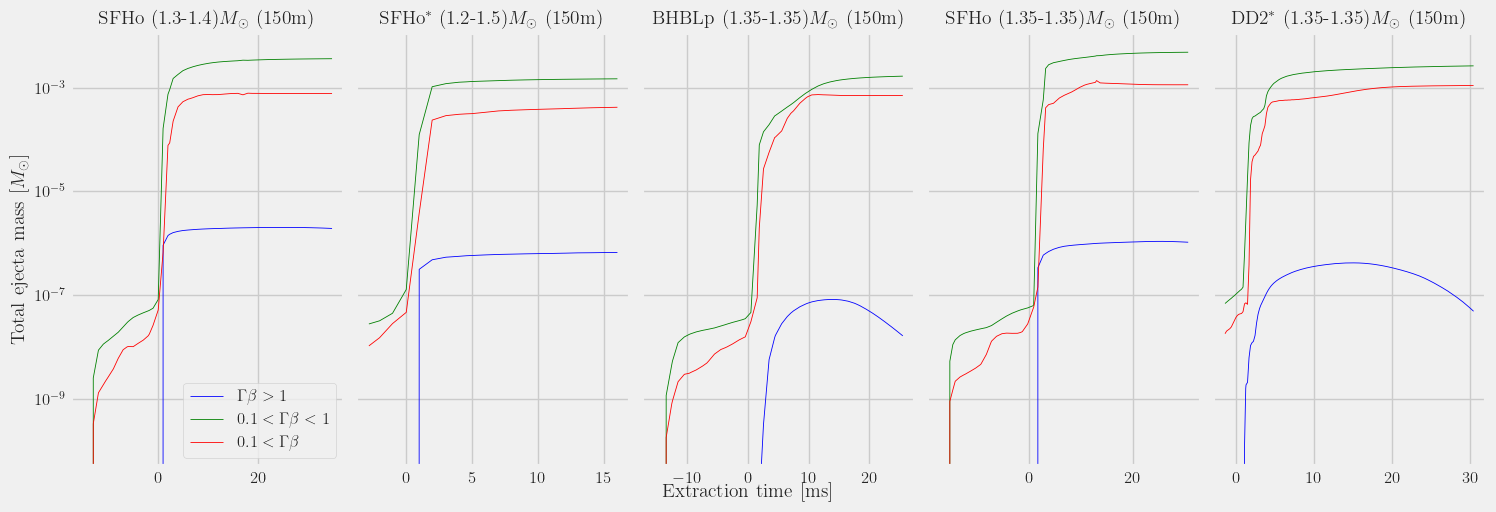

In [10]:
def plot_ejecta_mass_components_text(sim_dics:list[dict]):
    
    
    fig, axes = plt.subplots(ncols=len(sim_dics),nrows=1,sharey='all',figsize=(15,5))
    for i, sim_dic in enumerate(sim_dics):

        

        ej = PBA.id_kenta.EjectaData(sim_dic["datadir"] + "ej_collated.h5",verbose=True)

        tmerg = sim_dic["tmerg"]
        times = ej.getText()
        times = times - tmerg        

        ax = axes[i]
        ax.plot(times,ej.total_mass_vs_text(crit="fast"),color="blue",label=r"$\Gamma\beta > 1$",lw=.6)
        ax.plot(times,ej.total_mass_vs_text(crit="mid"),color="green",label=r"$0.1 < \Gamma\beta < 1$", lw=.6)
        ax.plot(times,ej.total_mass_vs_text(crit="slow"),color="red",label=r"$0.1 < \Gamma\beta$", lw=.6)
        # ax.plot([text_max_mass],[max_mass],marker='d',color='blue')
    
        ax.tick_params(labelsize=12)
        # ax.set_ylim(0,0.04)
        ax.set_yscale("log")
        if i == 0 : ax.legend(fontsize=12,ncol=1)
        # ax.set_yscale("linear")
        # ax.set_xlabel("Extraction time [ms]",fontsize=14)
        ax.set_title(sim_dic['label'], fontsize=14)
        # ax.grid(which="both",axis="both")
    axes[0].set_ylabel(r"Total ejecta mass $[M_{\odot}]$",fontsize=14)
    plt.tight_layout()
    # fig.title(r"Total ejecta mass vs $t_{rm ext}$"+sim_dic["label"])
    fig.text(0.5, 0.001, "Extraction time [ms]", fontsize=14, ha='center')
    plt.savefig(figs+f"mass_components.png",dpi=256)
    plt.savefig(pdfs+f"mass_components.pdf")
plot_ejecta_mass_components_text(sim_dics=[SIMULATIONS["SFHo_13_14_res150"],
                                           SIMULATIONS["SFHo_12_15_res150_B15_HLLD"],
                                           SIMULATIONS["BHBLp_135_135_res150"],
                                           SIMULATIONS["SFHo_135_135_res150_new"],
                                           SIMULATIONS["DD2_135_135_res150"]
                                           ])
plt.show()
# plot_ejecta_mass_components_text(dd=ej_data)

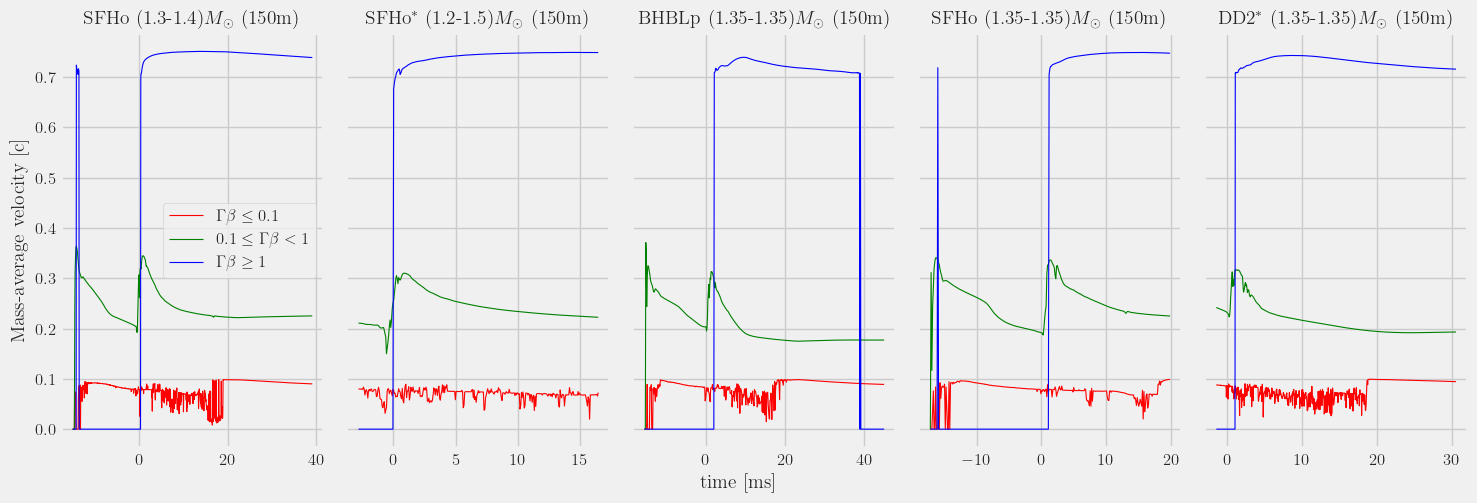

In [19]:
# Plot velocities
def plot_mdot_vave(sim_dics : [dict]):
    fig, axes = plt.subplots(ncols=len(sim_dics),nrows=1,sharey="all",figsize=(15,5))
    
    for i, sim_dic in enumerate(sim_dics):
        data = PBA.id_kenta.Data(fpath_rhomax=sim_dic["datadir"]+sim_dic["rhomax"],
                                 fpath_mdot=sim_dic["datadir"]+sim_dic["mdot_extract"])
    

        df = data.df_mdot
        tmerg = sim_dic["tmerg"]
        times = df["time"]
        times = times - tmerg

        ax = axes[i]
        ax.plot(times, df[f"vave_slow"],color="red",label=r"$\Gamma\beta \leq 0.1$", lw=.8)
        ax.plot(times, df[f"vave_mid"],color="green",label=r'$0.1 \leq \Gamma\beta < 1$',lw=.8)
        ax.plot(times, df[f"vave_fast"],color="blue",label=r'$\Gamma\beta \geq 1$', lw=.8)
        # ax.set_yscale("log")
        if i == 0: 
            ax.legend(loc="best",fontsize=12)
            ax.set_ylabel("Mass-average velocity [c]", fontsize=14)
        # ax.set_xlabel("time [ms]", fontsize=14)
        # ax.set_ylabel("Mass-average velocity [c]", fontsize=14)
        # ax.set_ylim(1e-9,1e-2)
        ax.tick_params(labelsize=12)

        ax.set_title(sim_dic['label'], fontsize=14)#(r"$\langle \upsilon \rangle$"+f" for {sim_dic['label']}")
    
    plt.tight_layout()
    fig.text(0.5, 0.001, "time [ms]", fontsize=14, ha='center')
    plt.savefig(figs+f"vave.png",dpi=256)
    plt.savefig(pdfs+f"vave.pdf")
    plt.show()
plot_mdot_vave(sim_dics=[SIMULATIONS["SFHo_13_14_res150"],
                         SIMULATIONS["SFHo_12_15_res150_B15_HLLD"],
                         SIMULATIONS["BHBLp_135_135_res150"],
                         SIMULATIONS["SFHo_135_135_res150_new"],
                         SIMULATIONS["DD2_135_135_res150"]
                         ])

In [21]:
# Definition of a retarded time for ejecta mass flux
def get_tret(r : float, vinf_ave0 : float =.7) -> float:
    vinf_ave0 = .7
    return (r*1000.*100./vinf_ave0/PBA.utils.cgs.c) * 1e3 # ms
def get_tret_arr(r : float, vinf_ave0 : np.ndarray) -> np.ndarray:
    vinf_ave0 = .7
    return (r*1000.*100./vinf_ave0/PBA.utils.cgs.c) * 1e3 # ms

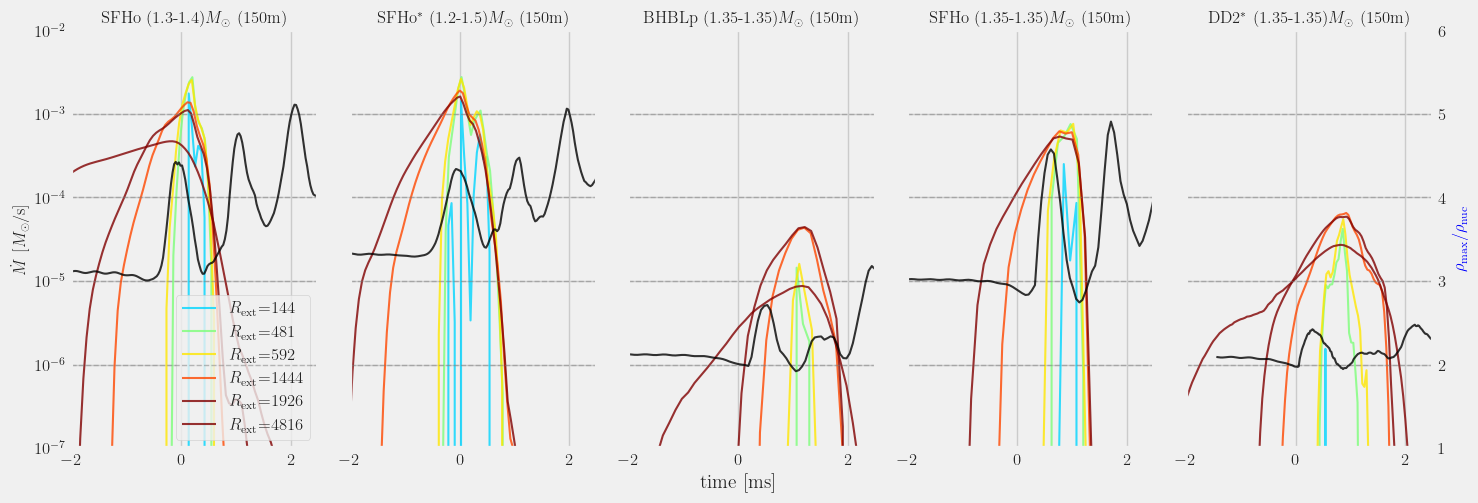

In [22]:
color_pal_ = sns.color_palette(n_colors=10)
norm = Normalize(vmin=0,vmax=6)
cmap = plt.cm.get_cmap('jet')
def plot_rho_mdot_rext(sim_dics:list[dict], ylim=(1e-7, 1e-2), ylim2=(1, 6), xlim=(-2, 2.5), crit="fast") -> None:
    fig, axes = plt.subplots(ncols=len(sim_dics), nrows=1, figsize=(15,5), sharey='all')
    for i, sim_dic in enumerate(sim_dics):


        data = PBA.id_kenta.Data(fpath_rhomax=sim_dic["datadir"]+sim_dic["rhomax"],
                                 fpath_mdot=sim_dic["datadir"]+sim_dic["mdot_extract"])
        rext = sorted(data.get_rext())
        # print(rext)
              
    
        time = data.df_mdot["time"]
        #color_pal = sns.color_palette(n_colors=len(rext)+1)

        tmerg = sim_dic["tmerg"]

        ax = axes[i]
        for j, r in enumerate(rext):
            tret = get_tret(r=r) # ms
            tret = get_tret_arr(r=r,vinf_ave0=data.df_mdot[f"vave_{crit}"]) # ms
            # ax.plot(time - tret- tmerg, data.df_mdot[f"mdot_fast_r{r}"], 
            #             color=color_pal_[j], label=r"$R_{\rm ext}$"+f"={r} [km]",lw=1,alpha=.9)
            vals = data.df_mdot[f"mdot_{crit}_r{r}"]
            if np.sum(vals) > 1e-10:
                ax.plot(time - tret- tmerg, vals, #color=color_pal_[j], 
                        color=cmap(norm(j)),
                        label=r"$R_{\rm ext}$"+f"={r}",lw=1.5,alpha=.8)
    
        # for i, r in enumerate(rext):
            # ax.plot(data.df_mdot["time"], data.df_mdot[f"mdot_fast_r{r}"],color=color_pal[i])
            # ax.plot(data.ret_time(r0=r,vave_key="vave_fast"), data.df_mdot[f"mdot_fast_r{r}"],color=color_pal[i])
            # df.plot("time",f"mdot_fast_r{r}",ax=ax,color=color_pal[i])
        
        
        ax2 = ax.twinx()
        ax2.plot(data.df_rho["time"]-tmerg, data.df_rho[f"rho_max"], color='black',lw=1.5,alpha=.8)
    
        # df.plot("time",f"rho_max",ax=ax2,color="black")
    
        # ax.set_xlabel("time [ms]", fontsize=12)
        #ax.set_ylabel("Mdot [Msun/s]", fontsize=12)
        #ax2.set_ylabel("rho max / rho nuc", fontsize=12)
        ax.set_yscale("log")
        # ax2.set_yscale("log")
        # ax.grid(color='black')
        ax2.grid(color='gray',ls='--',alpha=.5)
        ax2.tick_params(labelsize=12)
        # ax.legend(loc='lower right', fontsize=12)
        ax.tick_params(labelsize=12)
        if len(ylim) > 0 : ax.set_ylim(*ylim)
        if len(ylim2) > 0 : ax2.set_ylim(*ylim2)
        if len(xlim) > 0 : ax.set_xlim(*xlim)

        ax.set_title(sim_dic['label'], fontsize=12)#(r"$\dot{M}$ vs $\rho_{\rm max}$" + f" for {sim_dic['label']}", fontsize=14)

        if i!=len(sim_dics)-1:
            ax2.yaxis.set_ticklabels([])
        if i == 0:
            ax.legend(fontsize=12,loc='lower right')

    # axes[-1].legend(loc='lower right', fontsize=12)
    axes[0].set_ylabel(r"$\dot{M}$ [$M_{\odot}$/s]", fontsize=12)
    ax2.set_ylabel(r"$\rho_{\rm max}/\rho_{\rm nuc}$", color="blue",fontsize=12)

    fig.text(0.5, 0.001, "time [ms]", fontsize=14, ha='center')
    plt.tight_layout()
    # fig.text(0.5, 0.001, "time [ms]", fontsize=14, ha='center')
    plt.savefig(figs+"mdot_rhomax.png",dpi=256)
    plt.savefig(pdfs+"mdot_rext_rhomax.pdf")
    plt.show()
    
    # data.df_mdot.plot("time","mdot_fast_r48")
    # data.df_mdot.plot("time","mdot_fast_r144")
    # data.df_mdot.plot("time","mdot_fast_r482")
    # data.df_mdot.plot("time","mdot_fast_r144")
plot_rho_mdot_rext([SIMULATIONS["SFHo_13_14_res150"],
                    SIMULATIONS["SFHo_12_15_res150_B15_HLLD"],
                    SIMULATIONS["BHBLp_135_135_res150"],
                    SIMULATIONS["SFHo_135_135_res150_new"],
                    SIMULATIONS["DD2_135_135_res150"]
                    ])

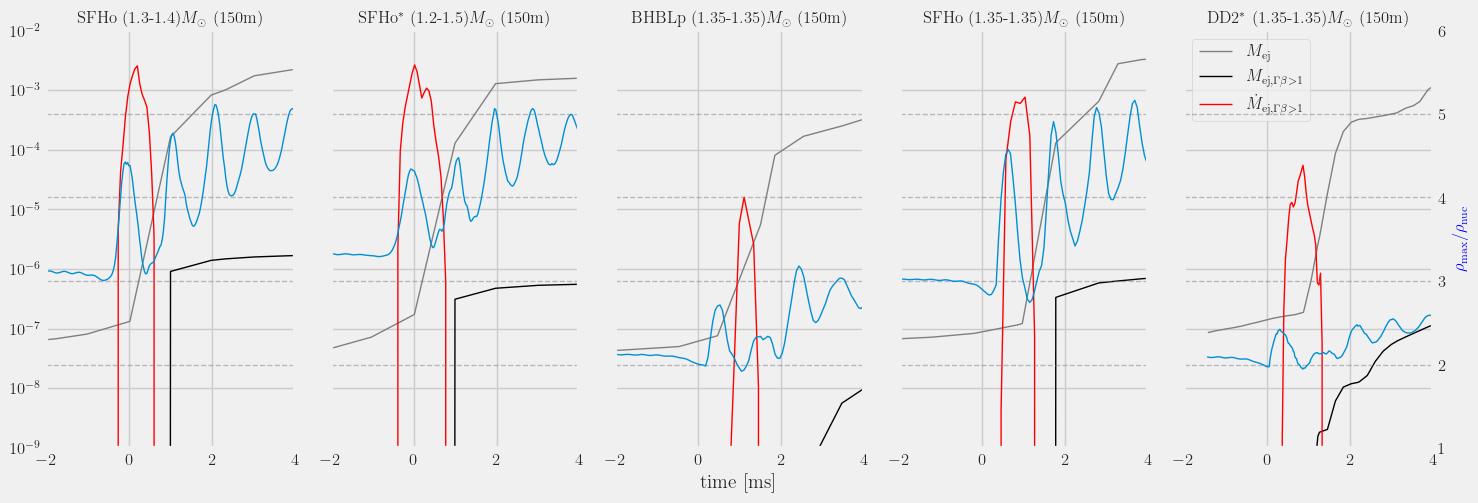

In [23]:
# print(data.get_rext())
def plot_mass_mdot_rho(sim_dics : list[dict], r=592, ylim=(1e-9, 1e-2), ylim2=(1,6), xlim=(-2, 4), crit="fast") -> None:
    fig, axes = plt.subplots(ncols=len(sim_dics), nrows=1, sharey="all", figsize=(15,5))
    for i, sim_dic in enumerate(sim_dics):
        
        ej_data = PBA.id_kenta.EjectaData(sim_dic["datadir"]+"ej_collated.h5",verbose=True)
        data = PBA.id_kenta.Data(fpath_rhomax=sim_dic["datadir"]+sim_dic["rhomax"],
                                 fpath_mdot=sim_dic["datadir"]+sim_dic["mdot_extract"])
        
        tmerg = sim_dic["tmerg"]
        tret = get_tret(r=r) # ms
        tret = get_tret_arr(r=r,vinf_ave0=data.df_mdot[f"vave_{crit}"]) # ms
    
        ax = axes[i]
        ax.plot(ej_data.getText()-tmerg, ej_data.total_mass(), color="gray",label=r"$M_{\rm ej}$", lw=1)
        ax.plot(ej_data.getText()-tmerg, ej_data.total_mass_vs_text(crit=crit),color="black",label=r"$M_{{\rm ej}, \Gamma\beta>1}$", lw=1)
        
        ax.plot(data.df_mdot["time"] - tret - tmerg, data.df_mdot[f"mdot_{crit}_r{r}"],color="red", label=r"$\dot{M}_{{\rm ej}, \Gamma\beta>1}$", lw=1)
        
        if len(ylim) > 0: ax.set_ylim(*ylim)
        ax.set_yscale("log")
        
        ax2 = ax.twinx()
        ax2.plot(data.df_rho["time"] - tmerg, data.df_rho[f"rho_max"], lw=1)#,label=r"$\rho_{\rm max}$", lw=2)  
        # data.df_rho.plot("time","rho_max",ax=ax2,color="green",label=r"$\rho_{\rm max}$")
        # data.df_mdot.plot("time","mdot_r481",ax=ax2,color="pink",label=r"$\dot{M}_{\rm ej}$")
        ax.set_yscale("log")
        ax.set_xlim(10,30)
        # ax.set_xlabel("time [ms]",fontsize=12)
        # ax.set_ylabel("Ejecta mass \& mass flux", color="black",fontsize=12)
        #ax2.set_ylabel("rho max / rho nuc", color="navy",fontsize=12)
        
        ax.tick_params(labelsize=12)
        ax2.tick_params(labelsize=12)
        #ax2.legend(fontsize=12)
        ax2.grid(color='gray',ls='--',alpha=.5)
        
        if len(ylim2) > 0: ax2.set_ylim(*ylim2)
        if len(ylim) > 0: ax.set_ylim(*ylim)
        if len(xlim) > 0 : ax.set_xlim(*xlim)

        if i!=len(sim_dics)-1:
            ax2.yaxis.set_ticklabels([])
        else:
            ax.legend(fontsize=12,loc='best')

        ax.set_title(sim_dic['label'], fontsize=12)#
            
        # ax.set_title()
    #axes[0].set_ylabel("Ejecta mass \& mass flux", color="black",fontsize=12)
    # axes[0].set_ylabel(r"$\dot{M}$ [$M_{\odot}$/s]", fontsize=12)
    ax2.set_ylabel(r"$\rho_{\rm max}/\rho_{\rm nuc}$", color="blue",fontsize=12)
    fig.text(0.5, 0.001, "time [ms]", fontsize=14, ha='center')
    plt.tight_layout()
    plt.savefig(figs+f"mdot_mej_rhomax.png",dpi=256)
    plt.show()
plot_mass_mdot_rho([SIMULATIONS["SFHo_13_14_res150"],
                    SIMULATIONS["SFHo_12_15_res150_B15_HLLD"],
                    SIMULATIONS["BHBLp_135_135_res150"],
                    SIMULATIONS["SFHo_135_135_res150_new"],
                    SIMULATIONS["DD2_135_135_res150"]
                    ])

In [24]:
# Sumamry
def print_summary(sim_dics:list[dict]):
    for sim_dic in sim_dics:
        
        data = PBA.id_kenta.EjectaData(sim_dic["datadir"]+"ej_collated.h5",verbose=True)
        # data = PBA.id_kenta.Data(fpath_rhomax=sim_dic["datadir"]+sim_dic["rhomax"],
        #                          fpath_mdot=sim_dic["datadir"]+sim_dic["mdot_extract"])
        print("-"*10+sim_dic["label"]+"-"*10)
        max_mass = np.max(data.total_mass_vs_text(crit="fast"))
        text_max_mass = data.getText()[np.argmax(data.total_mass_vs_text(crit="fast"))]
    
        print(f"Maximum fast of the fast tail: {max_mass:.2e} Msun at extraction time {text_max_mass:.1f} ms")
    
        ej_mass = data.get(v_n="mass",text=text_max_mass)
        ej_vinf = data.get_vinf()
        mask = data.get_vinf_mask(crit="fast")
        vave = np.sum(ej_mass[:,mask] * ej_vinf[mask])/np.sum(ej_mass[:,mask])
        print(f"Mass-averaged velocity of the fast tail at this extraction time: {vave:.2f} c")
    
        thetas = data.get_theta()
        theta_rms = (180. / np.pi) * np.sqrt(np.sum(np.sum(ej_mass[:,mask], axis=1) * thetas ** 2) / np.sum(ej_mass[:,mask]))
        print(f"theta_rms of the fast of the fast tail at this extraction time: {theta_rms:.2f} deg")
print_summary(sim_dics=[SIMULATIONS["SFHo_13_14_res150"],
                        SIMULATIONS["SFHo_12_15_res150_B15_HLLD"],
                        SIMULATIONS["BHBLp_135_135_res150"],
                        SIMULATIONS["SFHo_135_135_res150_new"],
                        SIMULATIONS["DD2_135_135_res150"]
                        ])

----------SFHo (1.3-1.4)$M_{\odot}$ (150m)----------
Maximum fast of the fast tail: 2.01e-06 Msun at extraction time 41.0 ms
Mass-averaged velocity of the fast tail at this extraction time: 0.74 c
theta_rms of the fast of the fast tail at this extraction time: 62.06 deg
----------SFHo$^*$ (1.2-1.5)$M_{\odot}$ (150m)----------
Maximum fast of the fast tail: 6.60e-07 Msun at extraction time 31.0 ms
Mass-averaged velocity of the fast tail at this extraction time: 0.75 c
theta_rms of the fast of the fast tail at this extraction time: 67.56 deg
----------BHBLp (1.35-1.35)$M_{\odot}$ (150m)----------
Maximum fast of the fast tail: 8.18e-08 Msun at extraction time 29.0 ms
Mass-averaged velocity of the fast tail at this extraction time: 0.73 c
theta_rms of the fast of the fast tail at this extraction time: 60.46 deg
----------SFHo (1.35-1.35)$M_{\odot}$ (150m)----------
Maximum fast of the fast tail: 1.08e-06 Msun at extraction time 43.0 ms
Mass-averaged velocity of the fast tail at this extra

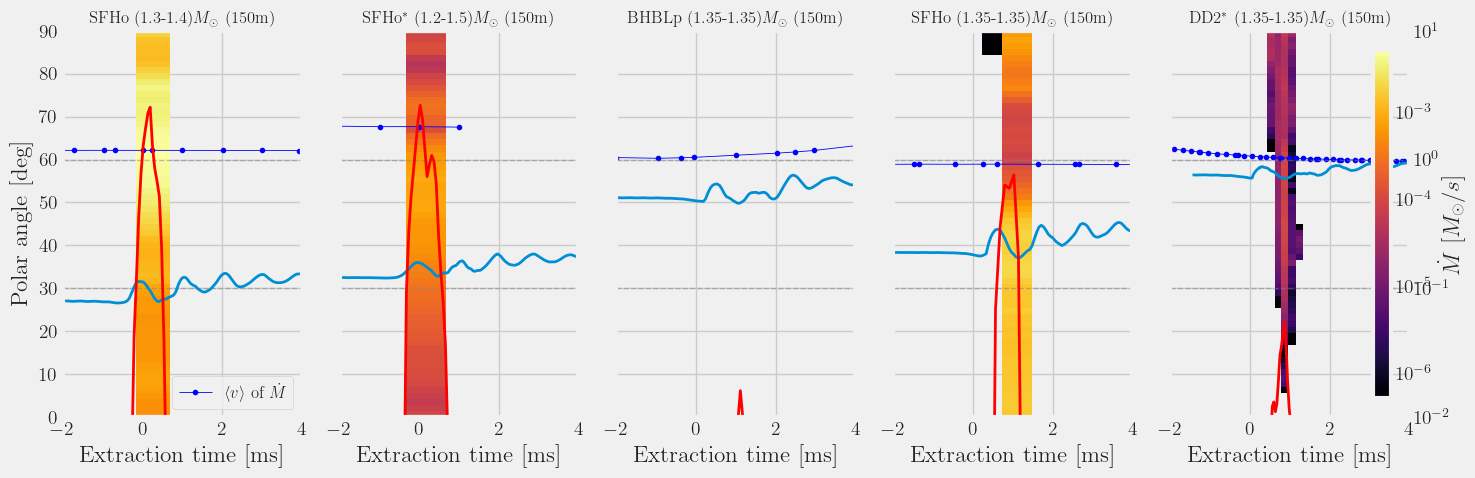

In [25]:
def plot_mdot2(sim_dics : list[dict],ylim=(0, 90), ylim2=(1e-5, 3e1), xlim=(-2, 4), rext=592, key="fast") -> None:
    fig, axes = plt.subplots(ncols=len(sim_dics), nrows=1, sharey="all", figsize=(15,5))
    norm = None
    for i, sim_dic in enumerate(sim_dics):
        data = PBA.id_kenta.Data(fpath_rhomax=sim_dic["datadir"]+sim_dic["rhomax"],
                                 fpath_mdot=sim_dic["datadir"]+sim_dic["mdot_extract"])
        ej_data = PBA.id_kenta.EjectaData(sim_dic["datadir"]+"ej_collated.h5",verbose=True)
        mdot_ej = PBA.id_kenta.EjectaData(sim_dic["datadir"]+"mdot_ej_collated.h5",verbose=True,mode="mdot")
        tmerg = sim_dic["tmerg"]
        ext_text = mdot_ej.getText()
        ext_radii = mdot_ej.get_rext()
        theta = mdot_ej.get_theta()
        
        mdot_example = mdot_ej.get(v_n=f"mdot_{key}",text=ext_text[3])
        # print(f"Extraction Radii shape={ext_radii.shape} ", ext_radii)
        # print(f"Extraction times shape={ext_text.shape} ", ext_text)
        # print(f"Mdot.shape()={mdot_example.shape}")
        # print(f"theta={theta.shape}", theta)
        ax = axes[i]
        # fig, ax = plt.subplots(ncols=1, nrows=1)
        # for t in mdot_ej.getText():
        #     vals = mdot_ej.get(v_n="mdot_fast",text=t).T
        #     print(f"t={t} sum_mdot={np.sum(vals)}")
        vals = np.zeros((len(mdot_ej.getText()),
                         len(mdot_ej.get_theta())))

        for it, t in enumerate(ext_text):
            _vals = mdot_ej.get(v_n="mdot_"+key,text=t).T
            idx = PBA.utils.find_nearest_index(ext_radii, rext)
            vals[it, :] = _vals[idx,:]

        vals[np.isnan(vals)] = 0.
        # vals = np.log10(vals)
        # print(np.sum(vals))

        #ax.imshow(vals,aspect=6)
        tret = get_tret_arr(r=rext,vinf_ave0=data.df_mdot[f"vave_"+key]) # ms

        if norm is None:
            norm = LogNorm(vmin=vals.max() * 1e-4, vmax=vals.max())
        _time = ext_text-tret-tmerg
        _theta = mdot_ej.get_theta() * 180 / np.pi
        _vals = vals.T
        _c = ax.pcolormesh(_time,_theta,_vals, cmap="inferno", norm=norm )
        

        ave_dic = get_vave_theta_rms(sim_dic=sim_dic, crit=key)
        _times = ave_dic["time"]
        _theta_rms = ave_dic["theta_rms"]
        # ax[1].plot(ext_text, vave, color=color_pal[idx], marker='.', lw=.6)
        ax.plot(_times - tmerg, _theta_rms, color="blue", marker='.', lw=.6, label=r"$\langle v \rangle$ of $\dot{M}$")

        # ax.set_ylabel("Polar angle [deg]")
        ax.set_xlabel("Extraction time [ms]")
        # ax.legend()

        ax2 = ax.twinx()
        rho_max = data.df_rho[f"rho_max"]
        ax2.plot(data.df_rho["time"] - tmerg, rho_max/rho_max.max(), label=r"$\rho_{\rm max}$", lw=2)
        ax2.plot(data.df_mdot["time"] - tret - tmerg, data.df_mdot[f"mdot_{key}_r{rext}"] * 1000,color="red", lw=2, label=r"$\dot{M}$")
        # ax2.set_ylim(1e-5,1e0)
        ax2.set_yscale("log")
        # ax2.legend()
        ax2.grid(color='gray',ls='--',alpha=.5)

        ax.set_xlim(5,25)

        if len(ylim) > 0 : ax.set_ylim(*ylim)
        if len(ylim2) > 0 : ax2.set_ylim(*ylim2)
        if len(xlim) > 0 : ax.set_xlim(*xlim)

        ax.set_title(sim_dic['label'], fontsize=12)#(r"$\dot{M}$ vs $\rho_{\rm max}$" + f" for {sim_dic['label']}", fontsize=14)

        if i!=len(sim_dics)-1:
            ax2.yaxis.set_ticklabels([])
        if i == 0:
            ax.legend(fontsize=12,loc='lower right')
    axes[0].set_ylabel("Polar angle [deg]")
    fig.colorbar(_c, ax=axes[-1],shrink=0.9,pad=.1,label=r"$\dot{M}$ $[M_{\odot}/s]$")
    plt.tight_layout()
    plt.savefig(figs+"mdot_theta_time_and_rho.png",dpi=256)
    plt.savefig(pdfs+"mdot_theta_time_and_rho.pdf")
    plt.show()
plot_mdot2(sim_dics=[SIMULATIONS["SFHo_13_14_res150"],
                     SIMULATIONS["SFHo_12_15_res150_B15_HLLD"],
                     SIMULATIONS["BHBLp_135_135_res150"],
                     SIMULATIONS["SFHo_135_135_res150_new"],
                     SIMULATIONS["DD2_135_135_res150"]
                     ],
           ylim=(0, 90), ylim2=(1e-2, 1e1), xlim=(-2, 4), rext=592, key="fast")